# Импорт библиотек

In [164]:
from math import cos, pi
from random import uniform
from random import random
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

# Функция Растригина

In [165]:
@njit
def f(x: np.ndarray):  # функция Растригина от -5.12 до 5.12
    a = 10
    result = 0
    n = len(x)
    for i in range(n):
        result += x[i] ** 2 - a * cos(2 * pi * x[i])

    return a * n + result

# Реализация метода роя частиц на Python с использованием numba

In [166]:
@njit
def main(v_max: float):
    px_list: np.ndarray
    py_list: np.ndarray
    best_solution: np.ndarray
    best_coord: np.ndarray

    dimension = 2  # размерность
    r1 = np.random.rand(dimension - 1)
    r2 = np.random.rand(dimension - 1)
    weight = 3.4
    p_global_best = 1000.0
    p_best_coordinates = np.zeros(dimension - 1)

    for j in range(10):
        coordinates = np.random.uniform(-5.12, 5.12, dimension - 1)
        c1 = random()
        c2 = random()
        p_coordinates_now = np.copy(coordinates)
        p_coordinates = np.copy(coordinates)
        p = f(coordinates)
        array_of_speed = np.zeros((10, dimension - 1))

        for k in range(dimension):
            array_of_speed[0][k] = uniform(-1 * v_max, v_max)

        for i in range(1, len(array_of_speed)):
            array_of_speed[i] = array_of_speed[i - 1] * weight + \
                                c1 * r1 * (p_best_coordinates - p_coordinates_now) + \
                                c2 * r2 * (p_best_coordinates - p_coordinates_now)

            for k in range(dimension):
                if array_of_speed[i][k] > 0:
                    array_of_speed[i][k] = min(array_of_speed[i][0], v_max)
                else:
                    array_of_speed[i][k] = max(array_of_speed[i][0], v_max)

            p_coordinates_now = p_coordinates_now + array_of_speed[i]

            if p > f(p_coordinates_now):
                p = f(p_coordinates_now)
                p_coordinates = p_coordinates_now

        if j == 0:
            px_list = np.copy(coordinates)
            py_list = np.array([p])
        else:
            px_list = np.append(px_list, coordinates)
            py_list = np.append(py_list, p)

        if p_global_best > p:
            p_best_coordinates = p_coordinates
            p_global_best = p

        if j == 0:
            best_solution = np.array([p_global_best])
            best_coord = np.copy(p_best_coordinates)
        else:
            best_solution = np.append(best_solution, p_global_best)
            best_coord = np.append(best_coord, p_best_coordinates)
    print("global_best:", p_global_best, "coordinates:", p_best_coordinates)
    print("Размерности совпадают: ", px_list.shape == py_list.shape)
    return [px_list, py_list], [best_coord, best_solution]

In [167]:
list_of_all = main(1.9)
list_of_x = list_of_all[0][0]
list_of_y = list_of_all[0][1]
list_of_best_coord = list_of_all[1][0]
list_of_best_solution = list_of_all[1][1]

global_best: 0.1988764406654262 coordinates: [0.03171353]
Размерности совпадают:  True


[-3.36170345 -4.51741912  2.04230842  3.10867527  5.06110241 -4.44898864
 -3.88387146  2.8092035  -1.91772008  1.3718176 ] 
 [19.44993614  7.28798602  4.52228014 11.90594083 26.34271443 11.62857443
  1.36373551 14.25695576  0.19887644 18.81015679]


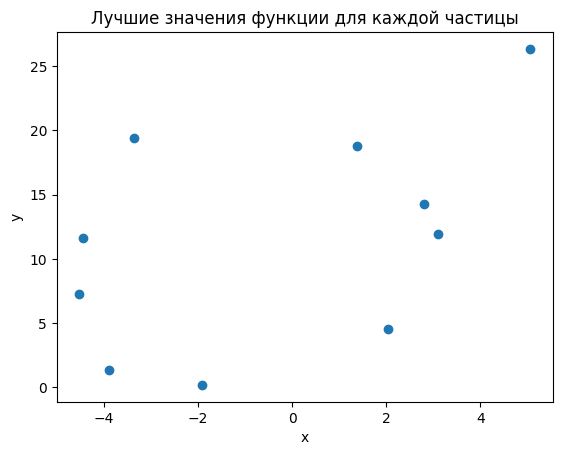

In [168]:
print(list_of_x, "\n", list_of_y)
plt.scatter(list_of_x, list_of_y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Лучшие значения функции для каждой частицы")
plt.show()

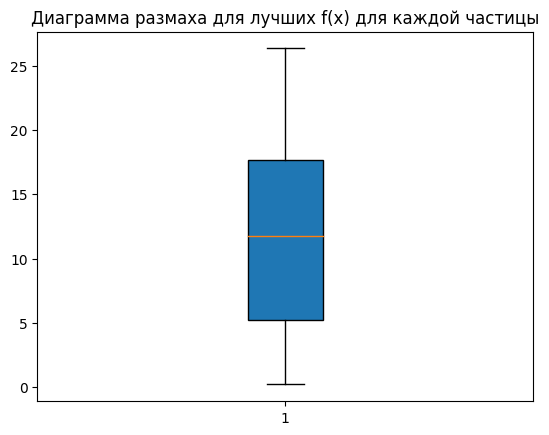

In [169]:
bp = plt.boxplot(list_of_y, patch_artist=True)  # диаграмма размаха для лучших f(x) для каждой частицы
plt.title("Диаграмма размаха для лучших f(x) для каждой частицы")
plt.show()

[ 0.43829655  1.18258088  2.04230842  2.04230842  2.04230842  2.04230842
 -0.08387146 -0.08387146  0.03171353  0.03171353] 
 [19.44993614  7.28798602  4.52228014  4.52228014  4.52228014  4.52228014
  1.36373551  1.36373551  0.19887644  0.19887644]


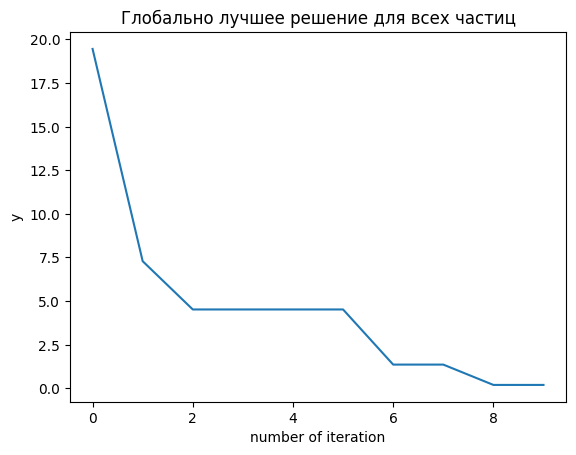

In [170]:
print(list_of_best_coord, "\n", list_of_best_solution)
plt.plot(np.arange(list_of_best_solution.size), list_of_best_solution)
plt.xlabel("number of iteration")
plt.ylabel("y")
plt.title("Глобально лучшее решение для всех частиц")
plt.show()